# Preliminary analysis: Bleaching experiment

This notebook is used to analyze some preliminary results of the bleaching experiments. That aimed to facilitate the nuclear structure recognition (in particular chromsomes and their intermingling regions) by sequential bleaching of a sample.

---

## 0. Environmental setup

In [1]:
from skimage import filters, segmentation, exposure, color, morphology, restoration, feature, measure
import numpy as np
import tifffile
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
import SimpleITK as sitk
from nd2reader import ND2Reader

# import the necessary packages
from __future__ import print_function
from skimage.feature import peak_local_max
from skimage.morphology import watershed
from scipy import ndimage
import cv2
import pywt

import sys

sys.path.append('..')

from src.utils.io import get_file_list
from src.utils.io import nd2_to_npy

In [2]:
def show_plane(ax, plane, cmap="gray", title=None):
    ax.imshow(plane, cmap=cmap)
    ax.axis("off")

    if title:
        ax.set_title(title)

        
def explore_slices(data, cmap="gray"):
    from ipywidgets import interact
    N = len(data)

    @interact(plane=(0, N - 1))
    def display_slice(plane=34):
        fig, ax = plt.subplots(figsize=(20, 10))

        show_plane(ax, data[plane], title="Plane {}".format(plane), cmap=cmap)

        plt.show()

    return display_slice

def explore_slices_n_samples(data, cmap="gray"):
    from ipywidgets import interact
    N = len(data[0])

    @interact(plane=(0, N - 1))
    def display_slice(plane=34):
        fig, ax = plt.subplots(figsize=(15, 30), nrows=4, ncols=2)
        ax = ax.flatten()
        
        for i in range(len(data)):
            show_plane(ax[i], data[i][plane], title="Sample {} || Plane {}".format(i,plane), cmap=cmap)

        plt.show()

    return display_slice


---

## 1. Read in data

We will now load the data from the one initial bleaching experiment by Saradha.

In [3]:
before_bleach = nd2_to_npy('/home/daniel/Desktop/bleaching_experiments/nuc_1_before_bleach_001.nd2')[0]
bleach_round1 = nd2_to_npy('/home/daniel/Desktop/bleaching_experiments/nuc_1_60_laser_rond1_002.nd2')[0]
bleach_round2 = nd2_to_npy('/home/daniel/Desktop/bleaching_experiments/nuc_1_60_laser_rond2_003.nd2')[0]
bleach_round3 = nd2_to_npy('/home/daniel/Desktop/bleaching_experiments/nuc_1_60_laser_rond3_004.nd2')[0]
bleach_round4 = nd2_to_npy('/home/daniel/Desktop/bleaching_experiments/nuc_1_60_laser_rond4_005.nd2')[0]
bleach_round5 = nd2_to_npy('/home/daniel/Desktop/bleaching_experiments/nuc_1_60_laser_rond5_006.nd2')[0]
bleach_round6 = nd2_to_npy('/home/daniel/Desktop/bleaching_experiments/nuc_1_60_laser_rond6_008.nd2')[0]

In [4]:
images = [before_bleach['image'], bleach_round1['image'], bleach_round2['image'], bleach_round3['image'], bleach_round4['image'], bleach_round5['image'], bleach_round6['image']]

In [5]:
explore_slices_n_samples(images, cmap='seismic')

interactive(children=(IntSlider(value=21, description='plane', max=21), Output()), _dom_classes=('widget-inter…

<function __main__.explore_slices_n_samples.<locals>.display_slice(plane=34)>

## 3. Difference maps

We will first look at the difference maps between the individual bleaching rounds to visualize the effect of the bleaching.

In [6]:
def calculate_difference_maps(images):
    difference_maps = []
    descriptions = []
    for i in range(len(images)-1):
        difference_map = []
        for j in range(i+1,len(images)):
            im1 = images[i]/images[i].max()
            im2 = images[j]/images[j].max()
            diff = abs(im1-im2)
            difference_maps.append(diff)
            descriptions.append('{}-{}'.format(i,j))
    return difference_maps, descriptions

In [7]:
difference_maps, descriptions = calculate_difference_maps(images)

#### Difference: Before bleaching vs after 1st bleaching

In [8]:
explore_slices(difference_maps[descriptions.index('0-2')])

interactive(children=(IntSlider(value=21, description='plane', max=21), Output()), _dom_classes=('widget-inter…

<function __main__.explore_slices.<locals>.display_slice(plane=34)>

#### Difference: Before bleaching vs after second bleaching

In [9]:
explore_slices(difference_maps[descriptions.index('0-4')])

interactive(children=(IntSlider(value=21, description='plane', max=21), Output()), _dom_classes=('widget-inter…

<function __main__.explore_slices.<locals>.display_slice(plane=34)>

#### Difference: Before bleaching vs after third bleaching

In [10]:
explore_slices(difference_maps[descriptions.index('0-6')])

interactive(children=(IntSlider(value=21, description='plane', max=21), Output()), _dom_classes=('widget-inter…

<function __main__.explore_slices.<locals>.display_slice(plane=34)>

#### Difference: After first bleaching vs after second bleaching

In [11]:
explore_slices(difference_maps[descriptions.index('2-4')])

interactive(children=(IntSlider(value=21, description='plane', max=21), Output()), _dom_classes=('widget-inter…

<function __main__.explore_slices.<locals>.display_slice(plane=34)>

#### Difference: After first bleaching vs after third bleaching

In [12]:
explore_slices(difference_maps[descriptions.index('2-6')])

interactive(children=(IntSlider(value=21, description='plane', max=21), Output()), _dom_classes=('widget-inter…

<function __main__.explore_slices.<locals>.display_slice(plane=34)>

#### Difference: After second bleaching vs after third bleaching

In [13]:
explore_slices(difference_maps[descriptions.index('4-6')])

interactive(children=(IntSlider(value=21, description='plane', max=21), Output()), _dom_classes=('widget-inter…

<function __main__.explore_slices.<locals>.display_slice(plane=34)>

---

## 4. Comparison based on thresholding

The effects of the bleaching seem to be relatively small. It appears that the bleaching might just preserve high intensity regions while removing lower intensities. We will further investigate that checking if the thresholded bleached samples coincide with a thresholding of the orginal feature maps.

To this end we will look at the problem in 2D using the max-z projection.

#### Absolute binary HC maps

In [14]:
before = images[0].max(axis=0)
bleached_1 = images[2].max(axis=0)
bleached_2 = images[4].max(axis=0)
bleached_3 = images[6].max(axis=0)

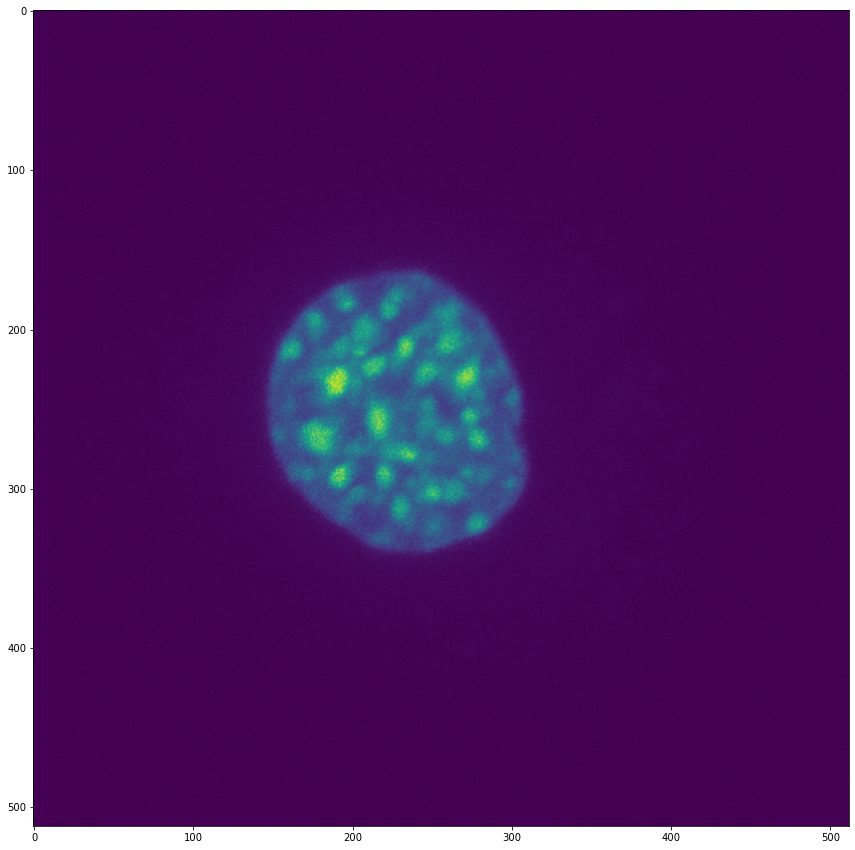

In [15]:
plt.figure(figsize=[15,15])
plt.imshow(before)

In [16]:
filtered_before = filters.median(before)
filtered_bleached_1 = filters.median(bleached_1)
filtered_bleached_2 = filters.median(bleached_2)
filtered_bleached_3 = filters.median(bleached_3)

In [17]:
k = 0.6
binary_before = filtered_before > filtered_before.min() + k * (filtered_before.max() - filtered_before.min())
binary_bleached_1 = filtered_bleached_1 > filtered_bleached_1.min() + k * (filtered_bleached_1.max() - filtered_bleached_1.min())
binary_bleached_2 = filtered_bleached_2 > filtered_bleached_2.min() + k * (filtered_bleached_2.max() - filtered_bleached_2.min())
binary_bleached_3 = filtered_bleached_3 > filtered_bleached_3.min() + k * (filtered_bleached_3.max() - filtered_bleached_3.min())

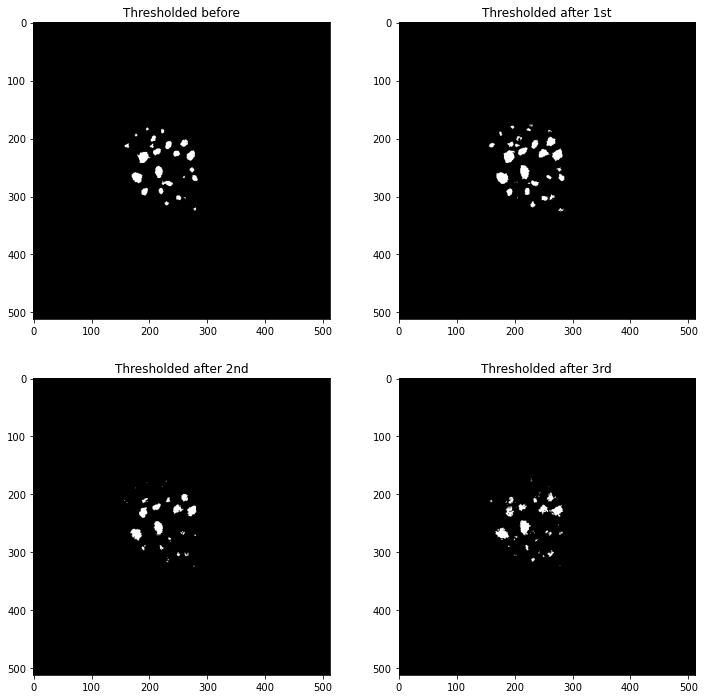

In [18]:
fig, ax = plt.subplots(figsize=(12, 12), nrows=2, ncols=2)
ax = ax.flatten()
ax[0].set_title('Thresholded before')
ax[0].imshow(binary_before, cmap='gray')
ax[1].set_title('Thresholded after 1st')
ax[1].imshow(binary_bleached_1, cmap='gray')
ax[2].set_title('Thresholded after 2nd')
ax[2].imshow(binary_bleached_2, cmap='gray')
ax[3].set_title('Thresholded after 3rd')
ax[3].imshow(binary_bleached_3, cmap='gray')


#### Difference binary HC maps

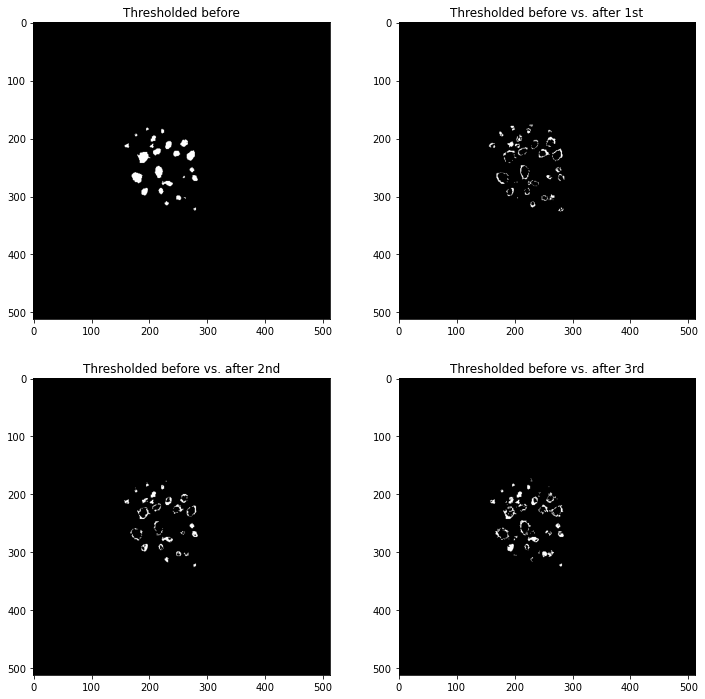

In [19]:
fig, ax = plt.subplots(figsize=(12, 12), nrows=2, ncols=2)
ax = ax.flatten()
ax[0].set_title('Thresholded before')
ax[0].imshow(binary_before, cmap='gray')
ax[1].set_title('Thresholded before vs. after 1st')
ax[1].imshow(np.logical_xor(binary_before, binary_bleached_1), cmap='gray')
ax[2].set_title('Thresholded before vs. after 2nd')
ax[2].imshow(np.logical_xor(binary_before, binary_bleached_2), cmap='gray')
ax[3].set_title('Thresholded before vs. after 3rd')
ax[3].imshow(np.logical_xor(binary_before, binary_bleached_3), cmap='gray')